# 1. Importing the dataset

In [28]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
import networkx as nx
from sklearn.feature_extraction.text import TfidfVectorizer


# Load data
with open("train.json") as f:
    data = json.load(f)

with open("test.json") as f:
    test_data = json.load(f)
df = pd.DataFrame(data)
df_test = pd.DataFrame(test_data)
seed = 42
np.random.seed(seed)


# 2. Exploratory Data Analysis (EDA)

In [2]:
#shape of data
df.shape

(29774, 3)

In [3]:
# no. of classes
print("No. of classes in train data: ",len(df['cuisine'].value_counts()))

No. of classes in train data:  20


In [29]:
df_test.shape

(10000, 2)

In [5]:
df.head()

id       cuisine                                        ingredients
0  42302   southern_us  [egg whites, pecans, agave nectar, ground cinn...
1  43202         greek  [large egg whites, whole milk, bread crumb fre...
2  31619  cajun_creole  [sugar, vegetable oil, yeast, eggs, evaporated...
3  30920        korean  [honey, rice vinegar, brown sugar, ginger, gar...
4  46567       italian  [mushroom caps, asiago, large shrimp, fat free...

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29774 entries, 0 to 29773
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           29774 non-null  int64 
 1   cuisine      29774 non-null  object
 2   ingredients  29774 non-null  object
dtypes: int64(1), object(2)
memory usage: 698.0+ KB


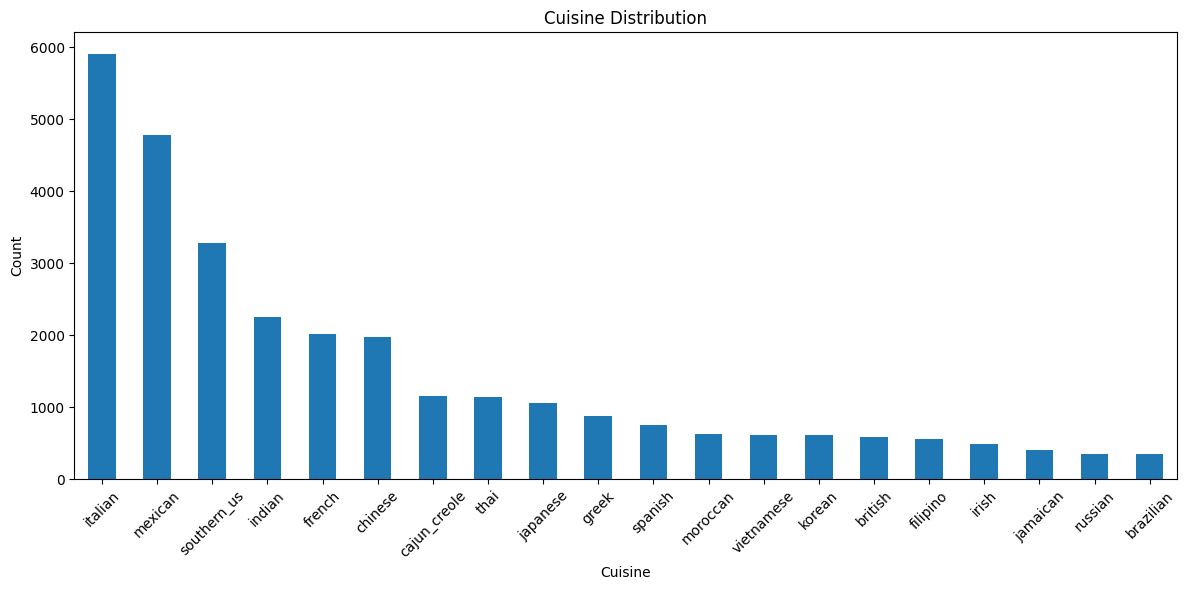

<Figure size 640x480 with 0 Axes>

In [7]:
all_ingredients = [ing.lower() for recipe in df["ingredients"] for ing in recipe]
ingredient_counts = Counter(all_ingredients)
top_ingredients = ingredient_counts.most_common(20)
cuisine_counts = df["cuisine"].value_counts()

# Plot 1. Cuisine distribution
plt.figure(figsize=(12, 6))
cuisine_counts.plot(kind="bar")
plt.title("Cuisine Distribution")
plt.xlabel("Cuisine")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("cuisine_distribution")


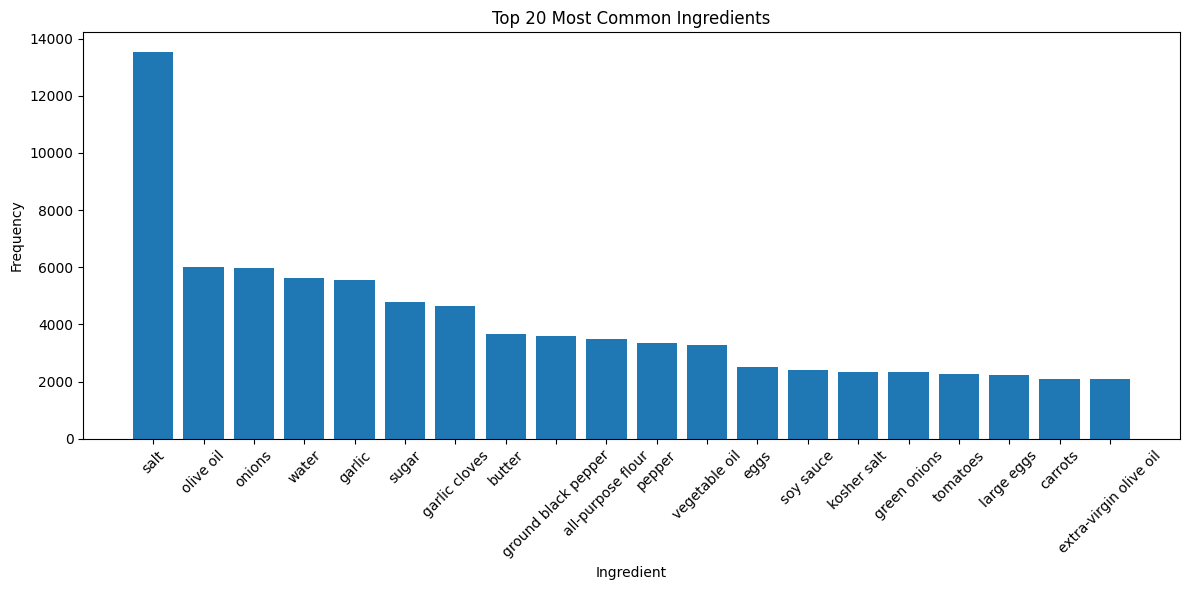

<Figure size 640x480 with 0 Axes>

In [8]:
# Plot 2. Top 20 most common ingredients
top_ing_names = [x[0] for x in top_ingredients]
top_ing_vals = [x[1] for x in top_ingredients]

plt.figure(figsize=(12, 6))
plt.bar(top_ing_names, top_ing_vals)
plt.title("Top 20 Most Common Ingredients")
plt.xlabel("Ingredient")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig("top_20_ingredients")

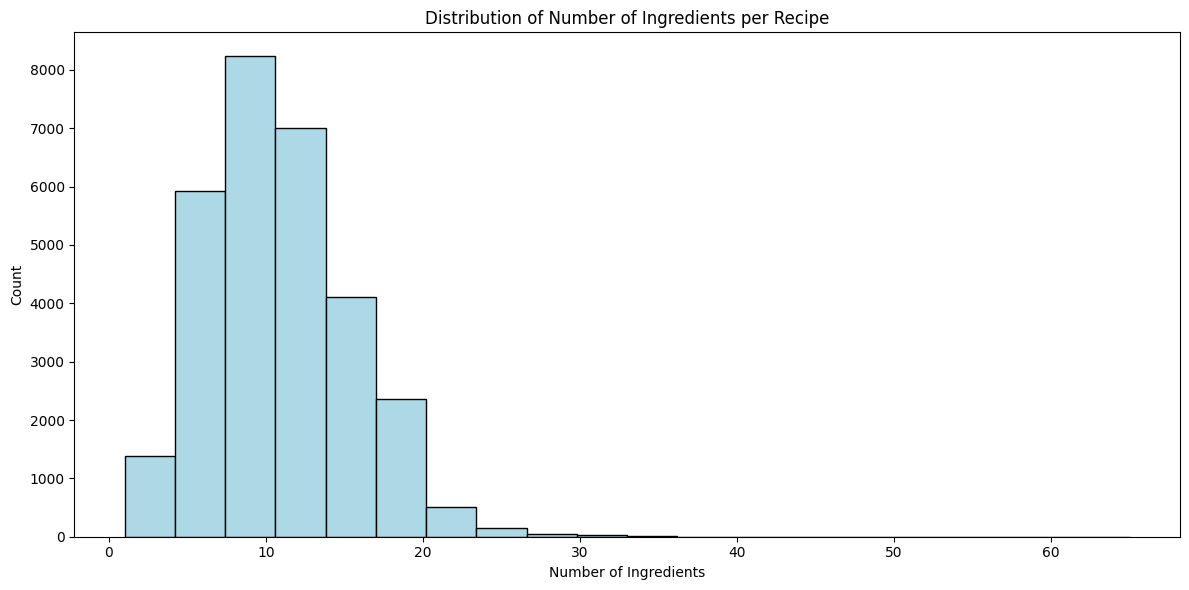

<Figure size 640x480 with 0 Axes>

In [30]:
# Plot 3. Ingredients per recipe distribution
df["num_ingredients"] = df["ingredients"].apply(len)
df_test['num_ingredients'] = df_test['ingredients'].apply(len)
plt.figure(figsize=(12, 6))
plt.hist(df["num_ingredients"], bins=20,edgecolor='black', color='lightblue')
plt.title("Distribution of Number of Ingredients per Recipe")
plt.xlabel("Number of Ingredients")
plt.ylabel("Count")
plt.tight_layout()
plt.show()
plt.savefig("ingredients_per_recipe")

<Figure size 1200x600 with 0 Axes>

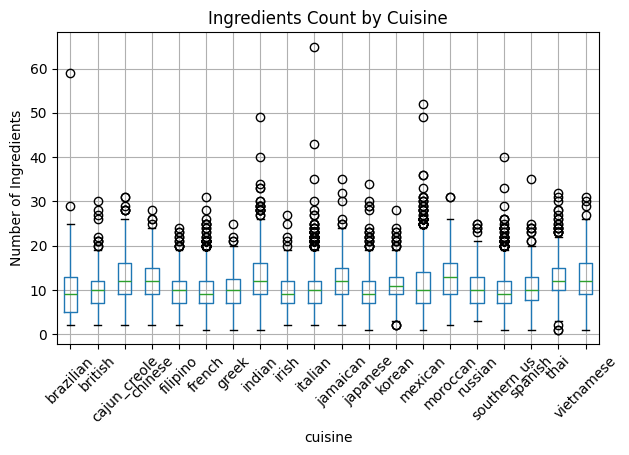

In [10]:
# Plot 4. Boxplot of ingredients per cuisine
plt.figure(figsize=(12, 6))
df.boxplot(column="num_ingredients", by="cuisine", rot=45)
plt.title("Ingredients Count by Cuisine")
plt.suptitle("")
plt.ylabel("Number of Ingredients")
plt.tight_layout()
plt.show()


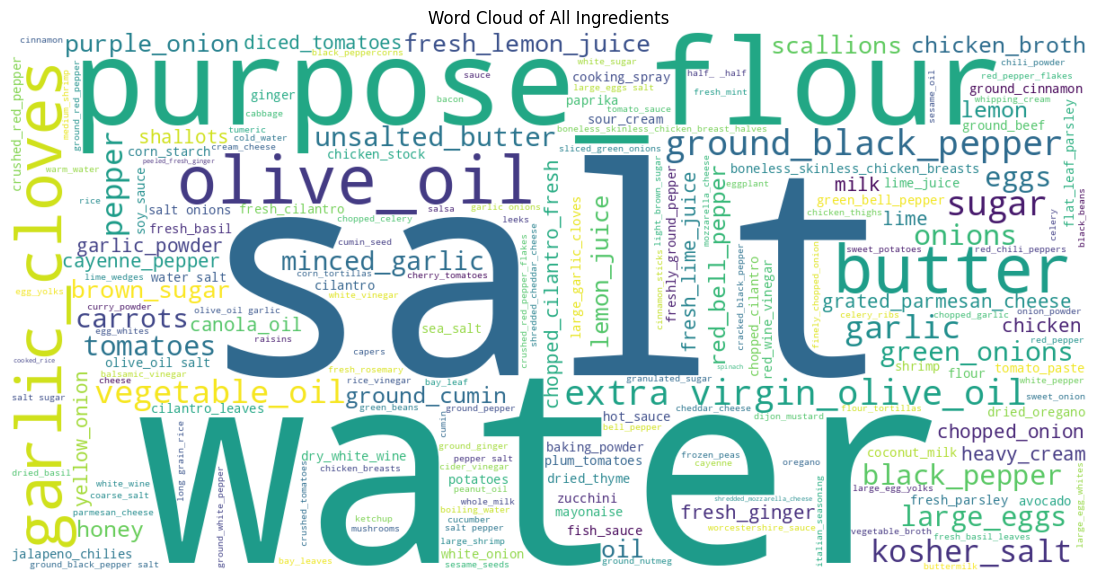

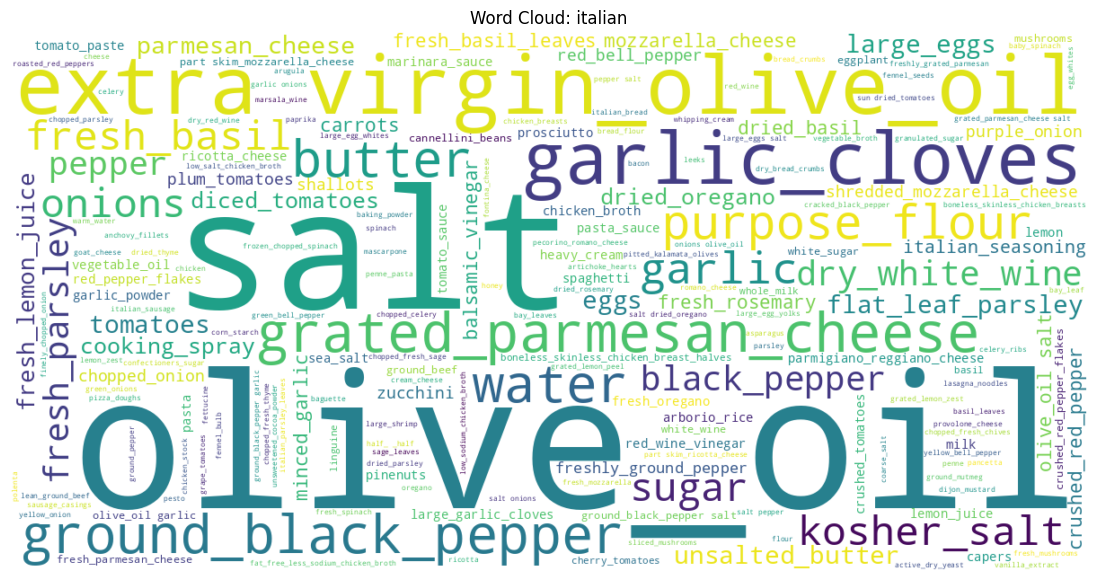

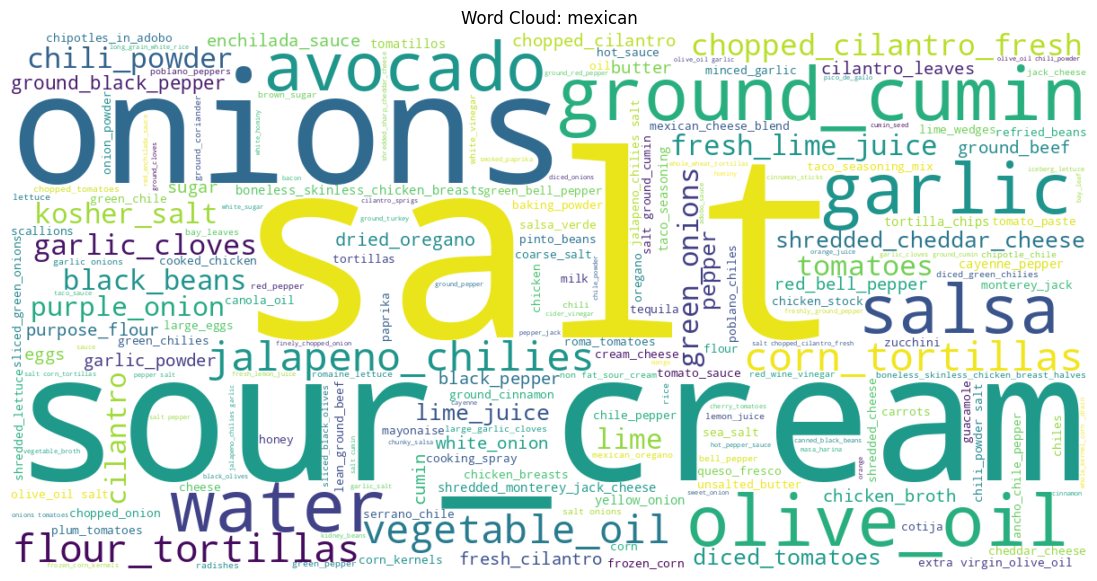

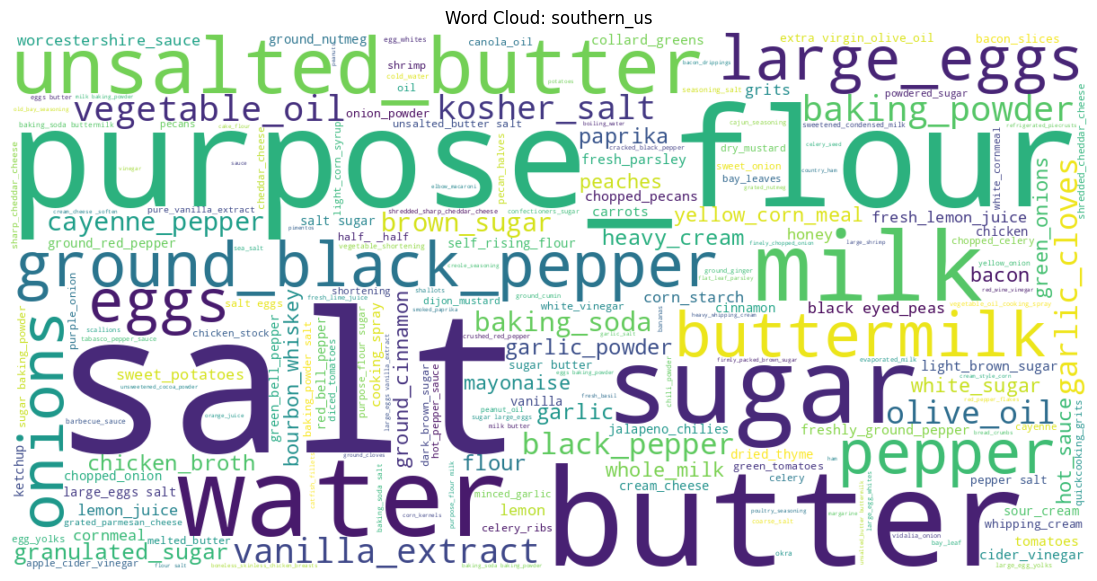

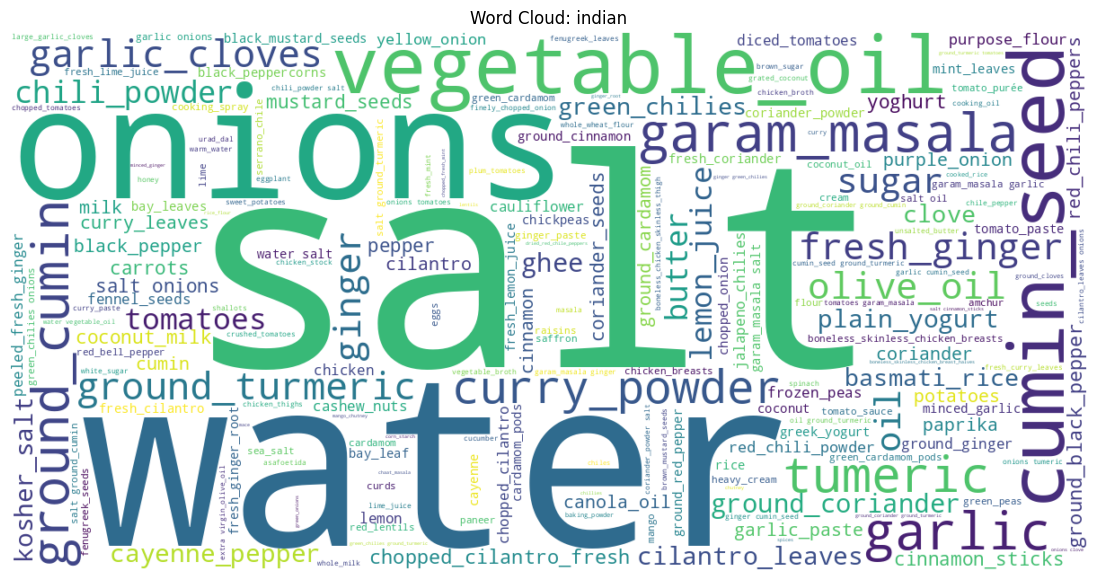

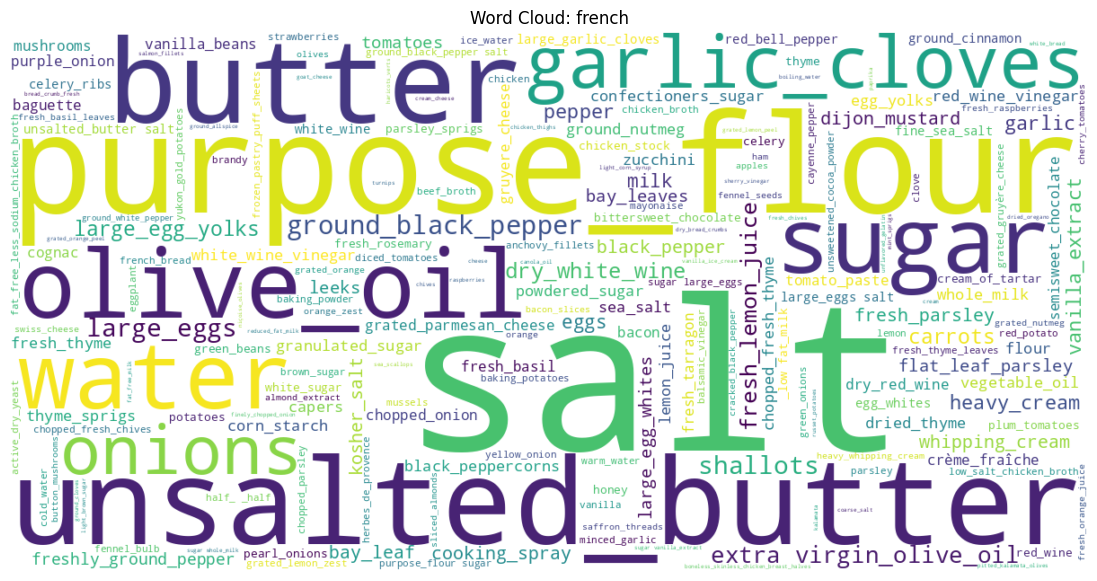

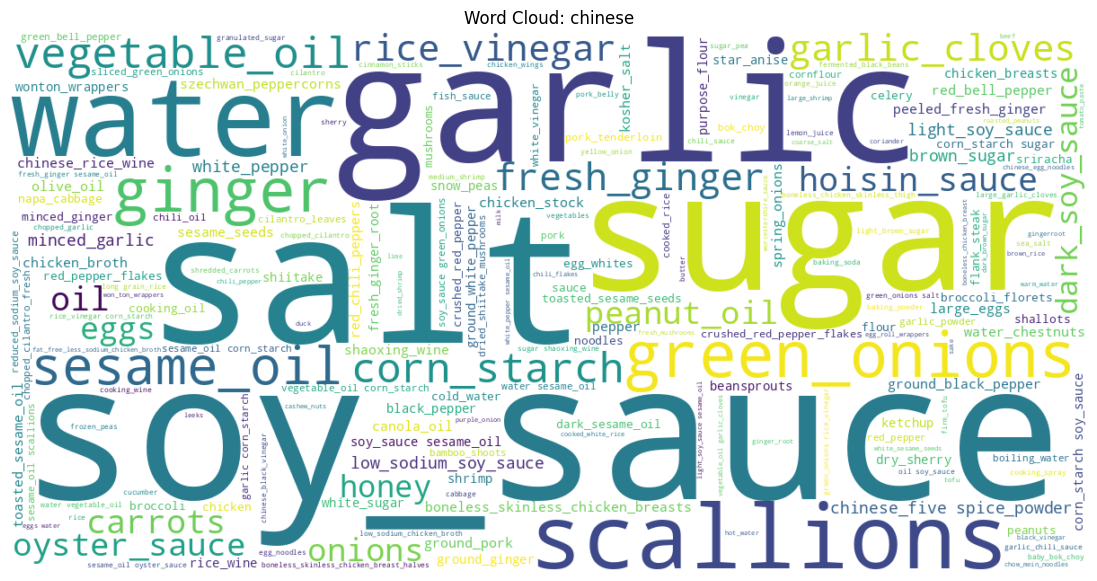

In [31]:
df["ingredients_str"] = df["ingredients"].apply(lambda x: " ".join([ing.lower().replace(" ", "_") for ing in x]))
df_test["ingredients_str"] = df_test["ingredients"].apply(lambda x: " ".join([ing.lower().replace(" ", "_") for ing in x]))
all_ingredients = " ".join(df["ingredients_str"].tolist())

wordcloud_all = WordCloud(width=1200, height=600, background_color="white").generate(all_ingredients)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud_all, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of All Ingredients")
plt.show()

# Word cloud for each cuisine (top 6 for clarity)
top_cuisines = df["cuisine"].value_counts().index[:6]

for cuisine in top_cuisines:
    subset = df[df["cuisine"] == cuisine]["ingredients_str"]
    text = " ".join(subset.tolist())
    wc = WordCloud(width=1200, height=600, background_color="white").generate(text)

    plt.figure(figsize=(14, 7))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud: {cuisine}")
    plt.show()



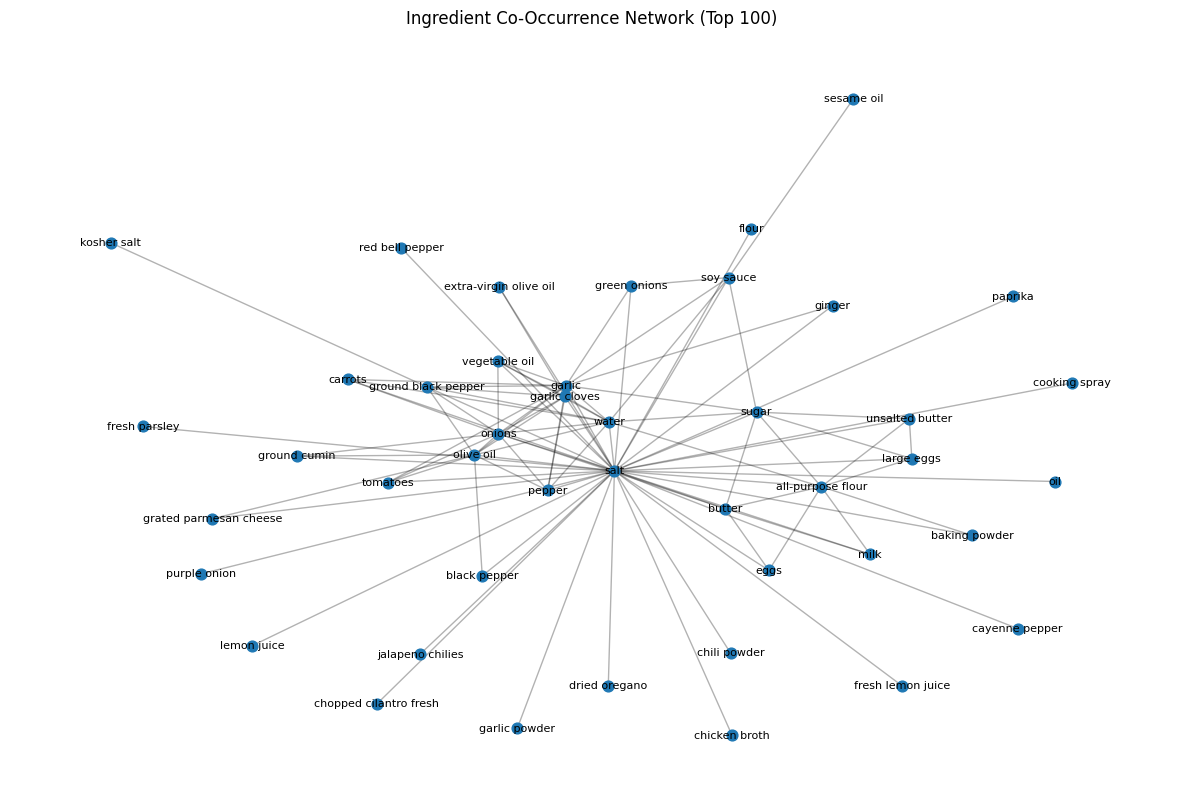

In [12]:

# Build pair counts
pair_counter = Counter()

for ingredients in df["ingredients"]:
    ingredients = [ing.lower() for ing in ingredients]
    unique = list(set(ingredients))
    for i in range(len(unique)):
        for j in range(i + 1, len(unique)):
            pair = tuple(sorted([unique[i], unique[j]]))
            pair_counter[pair] += 1

# Keep top 100 strongest co-occurrences
top_edges = pair_counter.most_common(100)

G = nx.Graph()
for (u, v), w in top_edges:
    G.add_edge(u, v, weight=w)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G, k=0.3)
nx.draw_networkx_nodes(G, pos, node_size=60)
nx.draw_networkx_edges(G, pos, alpha=0.3)
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Ingredient Co-Occurrence Network (Top 100)")
plt.axis("off")
plt.show()

In [13]:
from collections import defaultdict

class Tokenizer:
    def __init__(self, min_df=1, max_df=1.0):
        self.min_df = min_df
        self.max_df = max_df
        self.vocabulary = {}
        self.df = defaultdict(int)

    def fit(self, raw_documents):
        doc_count = len(raw_documents)
        for doc in raw_documents:
            unique_tokens = set(doc.split())
            for token in unique_tokens:
                self.df[token] += 1

        # Filter vocabulary based on min_df and max_df
        current_vocab_id = 0
        for token, count in self.df.items():
            if isinstance(self.min_df, int) and count < self.min_df:
                continue
            if isinstance(self.min_df, float) and count / doc_count < self.min_df:
                continue
            if isinstance(self.max_df, int) and count > self.max_df:
                continue
            if isinstance(self.max_df, float) and count / doc_count > self.max_df:
                continue

            self.vocabulary[token] = current_vocab_id
            current_vocab_id += 1
        return self

    def transform(self, raw_documents):
        tokenized_documents = []
        for doc in raw_documents:
            tokens = [token for token in doc.split() if token in self.vocabulary]
            tokenized_documents.append(tokens)
        return tokenized_documents

    def fit_transform(self, raw_documents):
        self.fit(raw_documents)
        return self.transform(raw_documents)

# Example usage with your ingredients_str column
ingredient_strings = df["ingredients_str"].tolist()

# Initialize and fit the tokenizer
tokenizer = Tokenizer(min_df=5, max_df=0.9)
tokenized_ingredients = tokenizer.fit_transform(ingredient_strings)

print(f"Vocabulary size: {len(tokenizer.vocabulary)}")
print(f"First 5 tokenized ingredient lists: {tokenized_ingredients[:5]}")

Vocabulary size: 2945
First 5 tokenized ingredient lists: [['egg_whites', 'pecans', 'agave_nectar', 'ground_cinnamon', 'sea_salt'], ['large_egg_whites', 'whole_milk', 'bread_crumb_fresh', 'large_eggs', 'lemon_wedge', 'french_bread', 'russet_potatoes', 'safflower_oil', 'olive_oil', 'green_onions'], ['sugar', 'vegetable_oil', 'yeast', 'eggs', 'evaporated_milk', 'confectioners_sugar', 'water', 'salt', 'shortening', 'flour', 'boiling_water'], ['honey', 'rice_vinegar', 'brown_sugar', 'ginger', 'garlic_cloves', 'chicken_wings', 'sesame_oil', 'gochujang_base', 'soy_sauce', 'salt'], ['mushroom_caps', 'asiago', 'large_shrimp', 'fat_free_less_sodium_chicken_broth', 'chopped_fresh_chives', 'garlic_cloves', 'fettucine', 'finely_chopped_onion', 'salt', 'olive_oil', 'dry_white_wine', 'flat_leaf_parsley']]


In [14]:
import numpy as np
from scipy.sparse import csr_matrix

class CustomTfidfVectorizer:
    def __init__(self, tokenizer=None, smooth_idf=True, sublinear_tf=False):
        self.tokenizer = tokenizer if tokenizer else Tokenizer()
        self.vocabulary = None
        self.idf_ = None
        self.smooth_idf = smooth_idf
        self.sublinear_tf = sublinear_tf

    def fit(self, raw_documents):
        tokenized_docs = self.tokenizer.fit_transform(raw_documents)
        self.vocabulary = self.tokenizer.vocabulary

        # Build term-frequency matrix (TF)
        row_ind, col_ind, data = [], [], []
        for doc_idx, tokens in enumerate(tokenized_docs):
            term_counts = Counter(tokens)
            for term, count in term_counts.items():
                if term in self.vocabulary:
                    row_ind.append(doc_idx)
                    col_ind.append(self.vocabulary[term])
                    data.append(count)

        num_docs = len(tokenized_docs)
        num_terms = len(self.vocabulary)
        tf_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(num_docs, num_terms), dtype=np.float64)

        # Calculate IDF
        df = np.bincount(tf_matrix.indices, minlength=num_terms) # Document frequency

        # Apply smooth_idf (add 1 to document frequencies and numerator for log calculation)
        if self.smooth_idf:
            df = df + 1
            n_samples = num_docs + 1
        else:
            n_samples = num_docs

        self.idf_ = np.log(n_samples / df) + 1.0 # Add 1 to ensure IDF values are >= 1

        return self

    def transform(self, raw_documents):
        if not self.vocabulary or self.idf_ is None:
            raise RuntimeError("Vectorizer not fitted. Call fit() first.")

        tokenized_docs = self.tokenizer.transform(raw_documents)

        row_ind, col_ind, data = [], [], []
        for doc_idx, tokens in enumerate(tokenized_docs):
            term_counts = Counter(tokens)
            for term, count in term_counts.items():
                if term in self.vocabulary:
                    row_ind.append(doc_idx)
                    col_ind.append(self.vocabulary[term])

                    # Apply sublinear_tf if True (1 + log(tf)) else just tf
                    tf_value = np.log(count) + 1 if self.sublinear_tf else count
                    data.append(tf_value)

        num_docs = len(tokenized_docs)
        num_terms = len(self.vocabulary)
        tf_matrix = csr_matrix((data, (row_ind, col_ind)), shape=(num_docs, num_terms), dtype=np.float64)

        # Multiply TF by IDF
        tfidf_matrix = tf_matrix.multiply(self.idf_)
        return tfidf_matrix

    def fit_transform(self, raw_documents):
        self.fit(raw_documents)
        return self.transform(raw_documents)

    def get_feature_names_out(self):
        # Returns terms in order of their vocabulary index
        return sorted(self.vocabulary, key=self.vocabulary.get)

In [17]:
# Initialize and fit the custom TF-IDF vectorizer
custom_tokenizer = Tokenizer(min_df=5, max_df=0.9)
custom_vectorizer = CustomTfidfVectorizer(tokenizer=custom_tokenizer)
X_custom_tfidf = custom_vectorizer.fit_transform(df["ingredients_str"])
feature_names_custom = custom_vectorizer.get_feature_names_out()

print("Shape of custom TF-IDF matrix:", X_custom_tfidf.shape)

Shape of custom TF-IDF matrix: (29774, 2945)


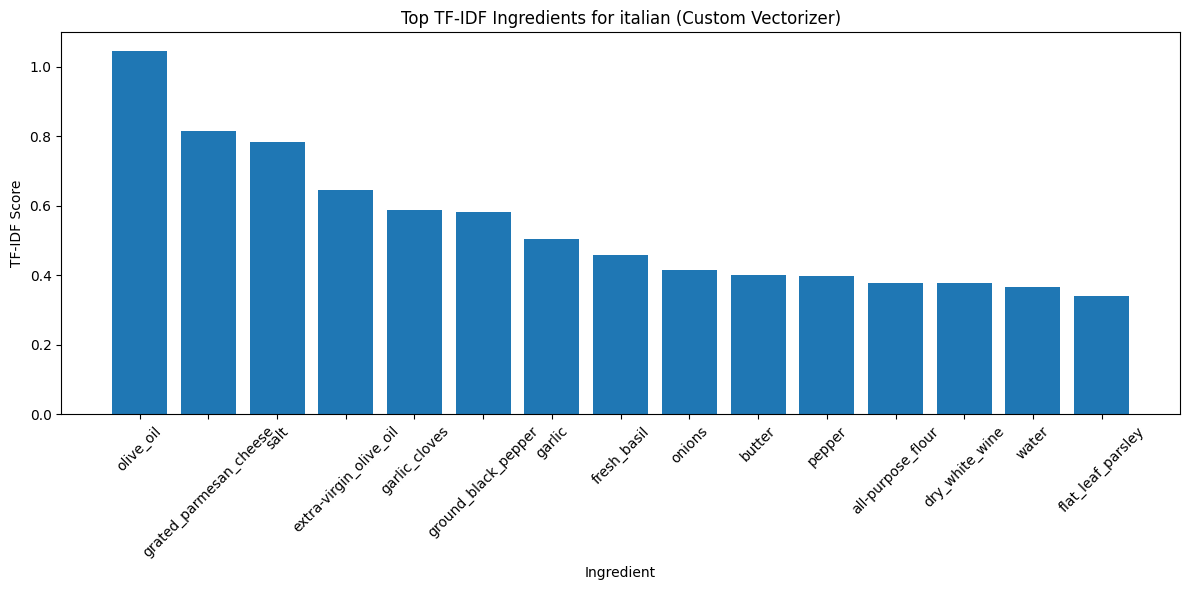

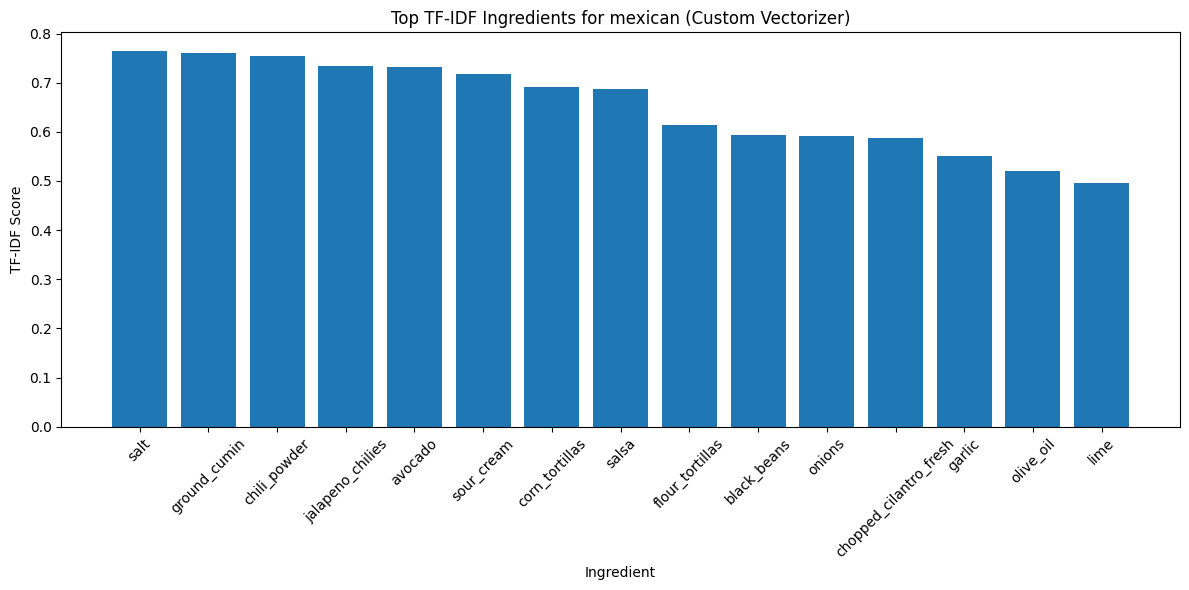

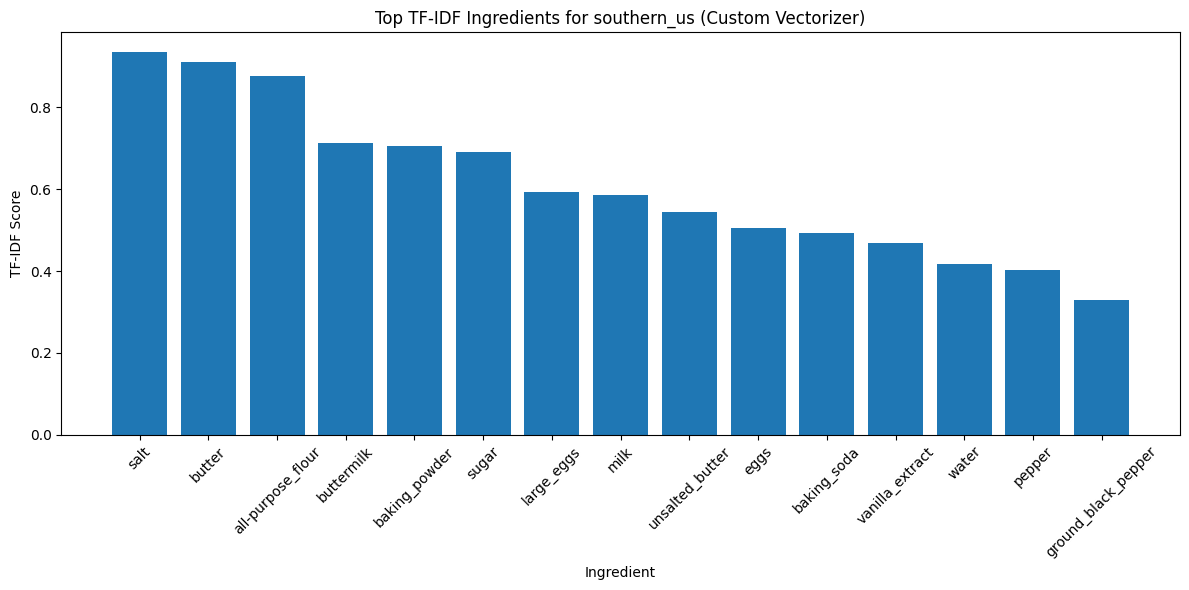

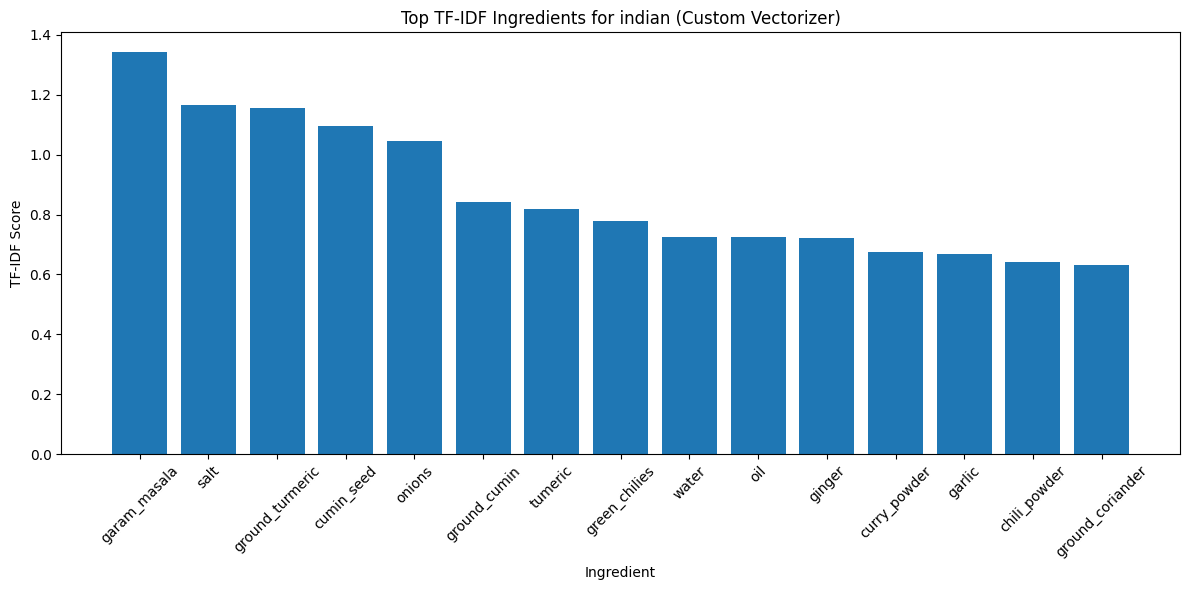

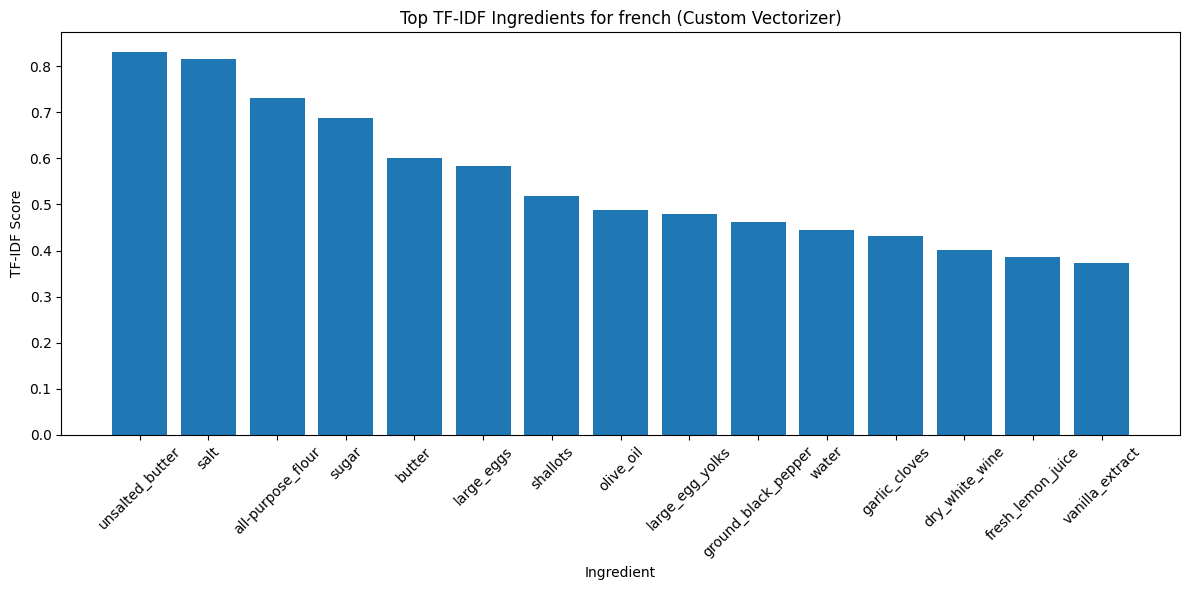

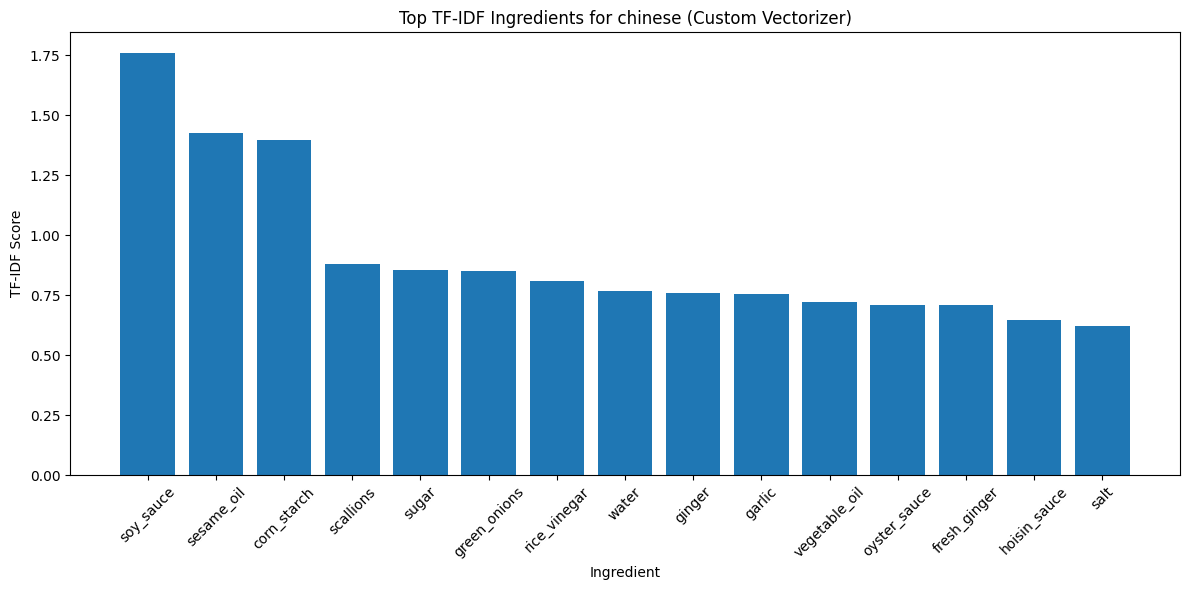

In [18]:
# Get top TF-IDF terms for each cuisine using the custom vectorizer
def top_tfidf_terms_custom(class_df, custom_vectorizer, top_n=15):
    subvec = custom_vectorizer.transform(class_df["ingredients_str"])
    mean_tfidf = subvec.mean(axis=0).A1

    # Get feature names directly from the custom_vectorizer's vocabulary
    feature_names = custom_vectorizer.get_feature_names_out()

    # Ensure top_n doesn't exceed available features
    actual_top_n = min(top_n, len(feature_names))
    top_idx = mean_tfidf.argsort()[::-1][:actual_top_n]
    return [(feature_names[i], mean_tfidf[i]) for i in top_idx]


for cuisine in top_cuisines:
    terms = top_tfidf_terms_custom(df[df["cuisine"] == cuisine], custom_vectorizer, top_n=15)

    labels = [t[0] for t in terms]
    scores = [t[1] for t in terms]

    plt.figure(figsize=(12, 6))
    plt.bar(labels, scores)
    plt.xticks(rotation=45)
    plt.title(f"Top TF-IDF Ingredients for {cuisine} (Custom Vectorizer)")
    plt.xlabel("Ingredient")
    plt.ylabel("TF-IDF Score")
    plt.tight_layout()
    plt.show()

# 3. Model Training

In [19]:
df_new = df.drop('ingredients',axis=1)

In [20]:
X_custom_tfidf.shape

(29774, 2945)

In [21]:
df_new

id       cuisine  num_ingredients  \
0      42302   southern_us                5   
1      43202         greek               11   
2      31619  cajun_creole               11   
3      30920        korean               10   
4      46567       italian               12   
...      ...           ...              ...   
29769  24516         greek               10   
29770  49253       mexican               17   
29771   4861        french               12   
29772    529       mexican                9   
29773  44209       italian                5   

                                         ingredients_str  
0      egg_whites pecans agave_nectar ground_cinnamon...  
1      large_egg_whites whole_milk bread_crumb_fresh ...  
2      sugar vegetable_oil yeast eggs evaporated_milk...  
3      honey rice_vinegar brown_sugar ginger garlic_c...  
4      mushroom_caps asiago large_shrimp fat_free_les...  
...                                                  ...  
29769  mayonaise mahimahi_fillet tomatoes extra-virgi...  
29770  neutral_oil ground_black_pepper tomatillos chi...  
29771  tomatoes chopped_fresh_thyme fresh_mushrooms e...  
29772  unsalted_butter chees_fresco_queso lime chili_...  
29773  baby_greens flat_leaf_parsley crabmeat extra-v...  

[29774 rows x 4 columns]

In [32]:
df_test.drop('ingredients',axis=1,inplace=True)
df_test

id  num_ingredients  \
0        14               12   
1        22               18   
2        24                9   
3        37                8   
4        40                8   
...     ...              ...   
9995  49692               10   
9996  49693                2   
9997  49697                9   
9998  49709                7   
9999  49710               15   

                                        ingredients_str  
0     olive_oil balsamic_vinegar toasted_pine_nuts k...  
1     canola jalapeno_chilies salsa onions cider_vin...  
2     large_eggs vanilla_extract firmly_packed_light...  
3     queso_fresco margarine chicken_breasts extra-v...  
4     active_dry_yeast white_sugar warm_water salt b...  
...                                                 ...  
9995  black_pepper vegetable_oil garlic_cloves unsal...  
9996                             crescent_rolls nutella  
9997  fennel_seeds bread_crumbs salt eggs crushed_re...  
9998  shallots salt red basil tomato_ketchup pepper ...  
9999  black_pepper salt fat plain_whole-milk_yogurt ...  

[10000 rows x 3 columns]

In [33]:
test_data = custom_vectorizer.transform(df_test["ingredients_str"])
test_data.shape

(10000, 2945)

In [34]:
from scipy.sparse import hstack

# Append 'num_ingredients' to the TF-IDF matrix
X = hstack([X_custom_tfidf, df_new[['num_ingredients']]])
test_data = hstack([test_data, df_test[['num_ingredients']]])
# Store the target variable
y = df_new["cuisine"]

print("Shape of X:", X.shape)
print("Shape of X test:", test_data.shape)
print("Shape of y:", y.shape)

Shape of X: (29774, 2946)
Shape of X test: (10000, 2946)
Shape of y: (29774,)


In [35]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=seed,stratify=y)

In [36]:
X_train.shape,y_train.shape

((22330, 2946), (22330,))

In [37]:
X_test.shape,y_test.shape

((7444, 2946), (7444,))


## 3.1 Support Vector Classifier

In [38]:
from sklearn.svm import SVC

model = SVC(kernel='rbf',C=2, random_state=seed, verbose=False)

model.fit(X_train, y_train)

SVC(C=2, random_state=42)

In [39]:
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.9493058665472458
0.7662547017732402


#3.2 Multinomial Logistic Regression

In [ ]:
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix

class MultinomialLogisticRegression:
    def __init__(self, learning_rate=0.1, n_iterations=1000, random_state=None):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.random_state = random_state
        self.weights = None
        self.bias = None
        self.classes_ = None
        self.label_encoder = LabelEncoder()

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def _cross_entropy_loss(self, y_true_encoded, y_proba):

        m = y_true_encoded.shape[0]
        y_proba = np.clip(y_proba, 1e-10, 1 - 1e-10)
        log_likelihood = -np.log(y_proba[np.arange(m), np.argmax(y_true_encoded, axis=1)])
        loss = np.sum(log_likelihood) / m
        return loss

    def fit(self, X, y):
        if self.random_state:
            np.random.seed(self.random_state)

        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        n_classes = len(self.classes_)

        y_one_hot = np.zeros((len(y_encoded), n_classes))
        y_one_hot[np.arange(len(y_encoded)), y_encoded] = 1

        n_samples, n_features = X.shape

        self.weights = np.zeros((n_features, n_classes), dtype=np.float64)
        self.bias = np.zeros((1, n_classes), dtype=np.float64)

        # Batch Gradient Descent
        for i in range(self.n_iterations):
            linear_model = X.dot(self.weights) + self.bias
            y_proba = self._softmax(linear_model)

            gradient = (y_proba - y_one_hot)
            dw = (X.T.dot(gradient)) / n_samples
            db = np.sum(gradient, axis=0, keepdims=True) / n_samples

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if i % 100 == 0:
                loss = self._cross_entropy_loss(y_one_hot, y_proba)
                print(f"Iteration {i}, Loss: {loss}")

        return self

    def predict_proba(self, X):
        linear_model = X.dot(self.weights) + self.bias
        return self._softmax(linear_model)

    def predict(self, X):
        probabilities = self.predict_proba(X)
        predicted_classes_encoded = np.argmax(probabilities, axis=1)
        return self.label_encoder.inverse_transform(predicted_classes_encoded)

    def score(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)


mlr_model = MultinomialLogisticRegression(learning_rate=0.5, n_iterations=1000, random_state=seed)
mlr_model.fit(X_train, y_train)

train_accuracy_mlr = mlr_model.score(X_train, y_train)
test_accuracy_mlr = mlr_model.score(X_test, y_test)

print(f"Multinomial Logistic Regression Training Accuracy: {train_accuracy_mlr:.4f}")
print(f"Multinomial Logistic Regression Test Accuracy: {test_accuracy_mlr:.4f}")


Iteration 0, Loss: 2.995732273553991
Iteration 100, Loss: 0.9226965202408937
Iteration 200, Loss: 0.6712765416958286
Iteration 300, Loss: 0.558881344567395
Iteration 400, Loss: 0.4959233086780643
Iteration 500, Loss: 0.45177165157947646
Iteration 600, Loss: 0.41829840267141377
Iteration 700, Loss: 0.3916527873442831
Iteration 800, Loss: 0.3699137146232152
Iteration 900, Loss: 0.35204230543317594
Multinomial Logistic Regression Training Accuracy: 0.9118
Multinomial Logistic Regression Test Accuracy: 0.7774


#3.3 Decision Tree

In [ ]:
X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

print(f"X_train_dense shape: {X_train_dense.shape}")
print(f"X_test_dense shape: {X_test_dense.shape}")

X_train_dense shape: (22330, 2946)
X_test_dense shape: (7444, 2946)


In [ ]:
import numpy as np
from collections import Counter


param_grid_dt = {
    'max_depth': [10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 3]
}


class Node:
    def __init__(self, feature_idx=None, threshold=None, left=None, right=None, *, value=None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

    def is_leaf_node(self):
        return self.value is not None

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2, min_samples_leaf=1, random_state=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.random_state = random_state
        self.root = None

        if self.random_state:
            np.random.seed(self.random_state)

    def _gini_impurity(self, y):
        '''Calculate Gini impurity for a set of labels y.'''
        if len(y) == 0:
            return 0

        class_counts = Counter(y)
        num_samples = len(y)

        gini = 1.0
        for label in class_counts:
            proportion = class_counts[label] / num_samples
            gini -= proportion**2
        return gini

    def _best_split(self, X, y):
        '''Find the best split (feature_idx, threshold) for the data X and labels y.'''
        n_samples, n_features = X.shape

        if n_samples < self.min_samples_split:
            return None, None

        parent_gini = self._gini_impurity(y)
        best_info_gain = -1
        best_feature_idx = None
        best_threshold = None

        for feature_idx in range(n_features):
            thresholds = np.unique(X[:, feature_idx])

            for threshold in thresholds:
                left_indices = np.where(X[:, feature_idx] <= threshold)[0]
                right_indices = np.where(X[:, feature_idx] > threshold)[0]

                if len(left_indices) < self.min_samples_leaf or len(right_indices) < self.min_samples_leaf:
                    continue

                y_left = y[left_indices]
                y_right = y[right_indices]

                n_left = len(y_left)
                n_right = len(y_right)
                n_total = n_left + n_right

                gini_left = self._gini_impurity(y_left)
                gini_right = self._gini_impurity(y_right)

                weighted_gini = (n_left / n_total) * gini_left + (n_right / n_total) * gini_right

                info_gain = parent_gini - weighted_gini

                if info_gain > best_info_gain:
                    best_info_gain = info_gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold

    def _build_tree(self, X, y, depth):
        '''Recursively builds the decision tree.'''
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common)

        feature_idx, threshold = self._best_split(X, y)

        if feature_idx is None:
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common)

        left_indices = np.where(X[:, feature_idx] <= threshold)[0]
        right_indices = np.where(X[:, feature_idx] > threshold)[0]

        if len(left_indices) == 0 or len(right_indices) == 0:
            most_common = Counter(y).most_common(1)[0][0]
            return Node(value=most_common)
        left_child = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_child = self._build_tree(X[right_indices], y[right_indices], depth + 1)

        return Node(feature_idx=feature_idx, threshold=threshold, left=left_child, right=right_child)

    def fit(self, X, y):
        '''Starts the recursive tree building process.'''
        y_np = y.to_numpy() if isinstance(y, pd.Series) else y
        self.root = self._build_tree(X, y_np, 0)
        return self

    def _traverse_tree(self, x, node):
        '''Recursively traverses the tree for a single sample x.'''
        if node.is_leaf_node():
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)

    def predict(self, X):
        '''Predicts class labels for multiple samples in X.'''
        return np.array([self._traverse_tree(x, self.root) for x in X])

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()

best_accuracy_dt = 0
best_params_dt = {}
best_dt_model = None


for max_depth_val in param_grid_dt['max_depth']:
    for min_samples_split_val in param_grid_dt['min_samples_split']:
        for min_samples_leaf_val in param_grid_dt['min_samples_leaf']:
            print(f"\nTraining DecisionTree with max_depth={max_depth_val}, min_samples_split={min_samples_split_val}, min_samples_leaf={min_samples_leaf_val}")

            dt_model_current = DecisionTree(max_depth=max_depth_val,
                                            min_samples_split=min_samples_split_val,
                                            min_samples_leaf=min_samples_leaf_val,
                                            random_state=seed)

            dt_model_current.fit(X_train_dense, y_train)
            y_test_pred_dt_current = dt_model_current.predict(X_test_dense)

            current_accuracy = np.mean(y_test_pred_dt_current == y_test)
            print(f"Test Accuracy: {current_accuracy:.4f}")

            if current_accuracy > best_accuracy_dt:
                best_accuracy_dt = current_accuracy
                best_params_dt = {
                    'max_depth': max_depth_val,
                    'min_samples_split': min_samples_split_val,
                    'min_samples_leaf': min_samples_leaf_val
                }
                best_dt_model = dt_model_current

print("\nManual Grid Search for Custom Decision Tree completed.")
print(f"Best Parameters: {best_params_dt}")
print(f"Best Test Accuracy: {best_accuracy_dt:.4f}")


Training DecisionTree with max_depth=10, min_samples_split=2, min_samples_leaf=1
Test Accuracy: 0.4018

Training DecisionTree with max_depth=10, min_samples_split=2, min_samples_leaf=3
Test Accuracy: 0.3995

Training DecisionTree with max_depth=10, min_samples_split=5, min_samples_leaf=1
Test Accuracy: 0.4013

Training DecisionTree with max_depth=10, min_samples_split=5, min_samples_leaf=3
Test Accuracy: 0.3995

Training DecisionTree with max_depth=15, min_samples_split=2, min_samples_leaf=1
Test Accuracy: 0.4447

Training DecisionTree with max_depth=15, min_samples_split=2, min_samples_leaf=3
Test Accuracy: 0.4426

Training DecisionTree with max_depth=15, min_samples_split=5, min_samples_leaf=1
Test Accuracy: 0.4437

Training DecisionTree with max_depth=15, min_samples_split=5, min_samples_leaf=3
Test Accuracy: 0.4426

Manual Grid Search for Custom Decision Tree completed.
Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 1}
Best Test Accuracy: 0.4447


In [ ]:
y_train_pred_dt = best_dt_model.predict(X_train_dense)
y_test_pred_dt = best_dt_model.predict(X_test_dense)

train_accuracy_dt = np.mean(y_train_pred_dt == y_train)
test_accuracy_dt = np.mean(y_test_pred_dt == y_test)

print(f"Custom Decision Tree Training Accuracy: {train_accuracy_dt:.4f}")
print(f"Custom Decision Tree Test Accuracy: {test_accuracy_dt:.4f}")

Custom Decision Tree Training Accuracy: 0.4741
Custom Decision Tree Test Accuracy: 0.4447


## 3.4 Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier


rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=seed, n_jobs=-1)

print("Training Random Forest model...")
rf_model.fit(X_train_dense, y_train)
print("Random Forest training complete.")

# Evaluate the model
y_train_pred_rf = rf_model.predict(X_train_dense)
y_test_pred_rf = rf_model.predict(X_test_dense)

train_accuracy_rf = np.mean(y_train_pred_rf == y_train)
test_accuracy_rf = np.mean(y_test_pred_rf == y_test)

print(f"\nRandom Forest Training Accuracy: {train_accuracy_rf:.4f}")
print(f"Random Forest Test Accuracy: {test_accuracy_rf:.4f}")

Training Random Forest model...
Random Forest training complete.

Random Forest Training Accuracy: 0.5173
Random Forest Test Accuracy: 0.4999


### Define Parameter Grid for Random Forest

**Subtask:** Create a dictionary specifying the hyperparameters to tune for the `RandomForestClassifier` (e.g., `n_estimators`, `max_depth`, `min_samples_split`, `min_samples_leaf`) and their respective ranges of values.

In [ ]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None], # None means unlimited depth
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Parameter grid for Random Forest defined successfully.")
print(param_grid_rf)

Parameter grid for Random Forest defined successfully.
{'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2]}


### Initialize and Fit GridSearchCV for Random Forest

**Subtask:** Initialize `RandomForestClassifier` and `GridSearchCV` with the model, the defined parameter grid, and an appropriate cross-validation strategy. Fit `GridSearchCV` to the training data (`X_train_dense`, `y_train`) to find the best hyperparameters for the Random Forest model.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Initialize RandomForestClassifier
rf_base_model = RandomForestClassifier(random_state=seed, n_jobs=-1)

# Initialize GridSearchCV
grid_search_rf = GridSearchCV(
    estimator=rf_base_model,
    param_grid=param_grid_rf,
    scoring='accuracy',
    cv=2,
    verbose=1,
    n_jobs=-1
)

print("Starting GridSearchCV fit process for Random Forest...")
grid_search_rf.fit(X_train_dense, y_train)
print("GridSearchCV fit process for Random Forest completed.")

# Get the best estimator and parameters
best_rf_model = grid_search_rf.best_estimator_
best_rf_params = grid_search_rf.best_params_

print(f"Best parameters found for Random Forest: {best_rf_params}")

# Evaluate the best model
train_accuracy_rf_grid = best_rf_model.score(X_train_dense, y_train)
test_accuracy_rf_grid = best_rf_model.score(X_test_dense, y_test)

print(f"Best Random Forest Training Accuracy (GridSearch): {train_accuracy_rf_grid:.4f}")
print(f"Best Random Forest Test Accuracy (GridSearch): {test_accuracy_rf_grid:.4f}")

Starting GridSearchCV fit process for Random Forest...
Fitting 2 folds for each of 36 candidates, totalling 72 fits
GridSearchCV fit process for Random Forest completed.
Best parameters found for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Random Forest Training Accuracy (GridSearch): 0.9997
Best Random Forest Test Accuracy (GridSearch): 0.7003


#3.5 Naive bayes

In [ ]:
import numpy as np
from collections import Counter

class CustomMultinomialNaiveBayes:
    def __init__(self, alpha=1.0):
        self.alpha = alpha  # Laplace smoothing parameter
        self.class_log_prior_ = None
        self.feature_log_probs_ = None
        self.classes_ = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        self.class_log_prior_ = np.zeros(n_classes)
        self.feature_log_probs_ = np.zeros((n_classes, n_features))

        for idx, c in enumerate(self.classes_):
            X_c = X[y == c]

            # Calculate prior probability P(C)
            self.class_log_prior_[idx] = np.log(len(X_c) / n_samples)

            if hasattr(X_c, 'toarray'):
                feature_counts = np.sum(X_c.toarray(), axis=0)
            else:
                feature_counts = np.sum(X_c, axis=0)

            smoothed_counts = feature_counts + self.alpha
            total_smoothed_counts = np.sum(smoothed_counts)

            # Calculate log-probability of each feature given the class P(feature|C)
            self.feature_log_probs_[idx, :] = np.log(smoothed_counts / total_smoothed_counts)

        return self

    def predict(self, X):
        predictions = []
        for x_sample in X:
            log_posteriors = []
            for idx, c in enumerate(self.classes_):
                # log(P(C)) + sum(x_i * log(P(feature_i|C)))
                prior = self.class_log_prior_[idx]


                if hasattr(x_sample, 'toarray'):
                    sample_features = x_sample.toarray().flatten()
                else:
                    sample_features = x_sample

                # Calculate likelihood sum: sum(x_i * log(P(feature_i|C)))
                likelihood_sum = np.sum(sample_features * self.feature_log_probs_[idx, :])

                log_posterior = prior + likelihood_sum
                log_posteriors.append(log_posterior)

            predictions.append(self.classes_[np.argmax(log_posteriors)])
        return np.array(predictions)

print("CustomMultinomialNaiveBayes class defined.")

CustomMultinomialNaiveBayes class defined.


In [ ]:
param_grid_mnb = {
    'alpha': [0.1, 0.5, 1.0, 5.0, 10.0, 20.0]
}


In [ ]:
best_accuracy_mnb_custom = 0
best_alpha_mnb_custom = None

for alpha_val in param_grid_mnb['alpha']:
    print(f"\nTraining Custom Multinomial Naive Bayes with alpha={alpha_val}")
    mnb_custom_model = CustomMultinomialNaiveBayes(alpha=alpha_val)
    mnb_custom_model.fit(X_train_dense, y_train)

    y_test_pred_mnb_custom = mnb_custom_model.predict(X_test_dense)
    current_accuracy_mnb_custom = np.mean(y_test_pred_mnb_custom == y_test)

    print(f"Test Accuracy for alpha={alpha_val}: {current_accuracy_mnb_custom:.4f}")

    if current_accuracy_mnb_custom > best_accuracy_mnb_custom:
        best_accuracy_mnb_custom = current_accuracy_mnb_custom
        best_alpha_mnb_custom = alpha_val

print("\nManual Grid Search for Custom Multinomial Naive Bayes completed.")
print(f"Best Alpha: {best_alpha_mnb_custom}")
print(f"Best Test Accuracy: {best_accuracy_mnb_custom:.4f}")


Training Custom Multinomial Naive Bayes with alpha=0.1
Test Accuracy for alpha=0.1: 0.7132

Training Custom Multinomial Naive Bayes with alpha=0.5
Test Accuracy for alpha=0.5: 0.7210

Training Custom Multinomial Naive Bayes with alpha=1.0
Test Accuracy for alpha=1.0: 0.7245

Training Custom Multinomial Naive Bayes with alpha=5.0
Test Accuracy for alpha=5.0: 0.7453

Training Custom Multinomial Naive Bayes with alpha=10.0
Test Accuracy for alpha=10.0: 0.7484

Training Custom Multinomial Naive Bayes with alpha=20.0
Test Accuracy for alpha=20.0: 0.7257

Manual Grid Search for Custom Multinomial Naive Bayes completed.
Best Alpha: 10.0
Best Test Accuracy: 0.7484


## 3.6 XGBoost

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

print("XGBoost and GridSearchCV imported successfully.")

XGBoost and GridSearchCV imported successfully.


In [ ]:
param_grid = {
    'n_estimators': [200],
    'learning_rate': [0.1],
    'max_depth': [4]
}

print("Parameter grid for XGBoost defined successfully.")
print(param_grid)

Parameter grid for XGBoost defined successfully.
{'n_estimators': [200], 'learning_rate': [0.1], 'max_depth': [4]}


In [ ]:
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

lb = LabelEncoder()
y_train_encoded = lb.fit_transform(y_train)
y_test_encoded = lb.transform(y_test)

base_xgb_model = XGBClassifier(objective='multi:softmax', eval_metric='mlogloss', use_label_encoder=False, random_state=seed, n_jobs=-1)


grid_search = GridSearchCV(estimator=base_xgb_model,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=2,
                           verbose=1, # Print progress messages
                           n_jobs=-1) # Use all available cores


print("Starting GridSearchCV fit process...")
grid_search.fit(X_train_dense, y_train_encoded)
print("GridSearchCV fit process completed.")


best_xgb_model = grid_search.best_estimator_
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

train_accuracy_xgb = best_xgb_model.score(X_train_dense, y_train_encoded)
test_accuracy_xgb = best_xgb_model.score(X_test_dense, y_test_encoded)

print(f"Best XGBoost Training Accuracy: {train_accuracy_xgb:.4f}")
print(f"Best XGBoost Test Accuracy: {test_accuracy_xgb:.4f}")

Starting GridSearchCV fit process...
Fitting 2 folds for each of 1 candidates, totalling 2 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [09:42:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV fit process completed.
Best parameters found: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200}
Best XGBoost Training Accuracy: 0.7946
Best XGBoost Test Accuracy: 0.7284


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

# Initialize LGBMClassifier
# Using objective='multiclass' and num_class=len(lb.classes_) for multi-class classification
lgbm_model = LGBMClassifier(objective='multiclass', num_class=len(lb.classes_), random_state=seed, n_jobs=-1)

# Train the LightGBM model
print("Training LightGBM model...")
lgbm_model.fit(X_train_dense, y_train_encoded)
print("LightGBM training complete.")

# Make predictions
y_train_pred_lgbm = lgbm_model.predict(X_train_dense)
y_test_pred_lgbm = lgbm_model.predict(X_test_dense)

# Calculate accuracies
train_accuracy_lgbm = accuracy_score(y_train_encoded, y_train_pred_lgbm)
test_accuracy_lgbm = accuracy_score(y_test_encoded, y_test_pred_lgbm)

print(f"\nLightGBM Training Accuracy: {train_accuracy_lgbm:.4f}")
print(f"LightGBM Test Accuracy: {test_accuracy_lgbm:.4f}")



Training LightGBM model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.186232 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 22330, number of used features: 1240
[LightGBM] [Info] Start training from score -4.496233
[LightGBM] [Info] Start training from score -3.947578
[LightGBM] [Info] Start training from score -3.254431
[LightGBM] [Info] Start training from score -2.717273
[LightGBM] [Info] Start training from score -3.985408
[LightGBM] [Info] Start training from score -2.681971
[LightGBM] [Info] Start training from score -3.532109
[LightGBM] [Info] Start training from score -2.578248
[LightGBM] [Info] Start training from score -4.113789
[LightGBM] [Info] Start training from score -1.625691
[LightGBM] [Info] Start training from score -4.330107
[LightGBM] [Info] Start 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



LightGBM Training Accuracy: 0.9332
LightGBM Test Accuracy: 0.7567


In [ ]:
param_grid_lgbm = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [10,100,-1]
}

print("Parameter grid for LightGBM defined successfully.")
print(param_grid_lgbm)

Parameter grid for LightGBM defined successfully.
{'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 'max_depth': [10, 100, -1]}


In [ ]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Initialize LGBMClassifier
lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train_encoded)), # Get number of unique classes from encoded labels
    random_state=seed,
    n_jobs=-1
)

# Initialize GridSearchCV
grid_search_lgbm = GridSearchCV(
    estimator=lgbm_model,
    param_grid=param_grid_lgbm,
    scoring='accuracy',
    cv=2,
    verbose=1,
    n_jobs=-1
)

print("Starting GridSearchCV fit process for LightGBM...")
grid_search_lgbm.fit(X_train_dense, y_train_encoded)
print("GridSearchCV fit process for LightGBM completed.")

# Get the best estimator and parameters
best_lgbm_model = grid_search_lgbm.best_estimator_
best_lgbm_params = grid_search_lgbm.best_params_

print(f"Best parameters found for LightGBM: {best_lgbm_params}")

# Evaluate the best model
train_accuracy_lgbm_grid = best_lgbm_model.score(X_train_dense, y_train_encoded)
test_accuracy_lgbm_grid = best_lgbm_model.score(X_test_dense, y_test_encoded)

print(f"Best LightGBM Training Accuracy (GridSearch): {train_accuracy_lgbm_grid:.4f}")
print(f"Best LightGBM Test Accuracy (GridSearch): {test_accuracy_lgbm_grid:.4f}")

Starting GridSearchCV fit process for LightGBM...
Fitting 2 folds for each of 12 candidates, totalling 24 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196014 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2522
[LightGBM] [Info] Number of data points in the train set: 22330, number of used features: 1240
[LightGBM] [Info] Start training from score -4.496233
[LightGBM] [Info] Start training from score -3.947578
[LightGBM] [Info] Start training from score -3.254431
[LightGBM] [Info] Start training from score -2.717273
[LightGBM] [Info] Start training from score -3.985408
[LightGBM] [Info] Start training from score -2.681971
[LightGBM] [Info] Start training from score -3.532109
[LightGBM] [Info] Start training from score -2.578248
[LightGBM] [Info] Start training from score -4.113789
[LightGBM] [Info] Start training from score -1.6

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Best LightGBM Training Accuracy (GridSearch): 0.9323
Best LightGBM Test Accuracy (GridSearch): 0.7569
